In [1]:
from agent import Agent
from doubleAgent import DoubleAgent
from memory import Memory
from qNetwork import QNetwork

import os
import torch
import math
import Target_Terminator as gym
from torch import nn

In [2]:
DOUBLE_AGENT = True

DEVICE = "cpu"
RENDER_MODE = ""

# Env data
N_ACTIONS = 5

# Agent data
START_EPSILON = 1
DECAY = 0.9996
FINAL_EPSILON = 0.01

# Memory data
MEMORY_SIZE = 128_000

# Training settings
NUMBER_OF_EPISODES = 10
NUMBER_OF_EPISODES_TO_AVERAGE = 100
THRESHOLD_STOP_CONDITION = 30_000
DISCOUNT_GAMMA = 0.99
MEMORY_BATCH_SIZE_PER_TRAINING_STEP = 128
STEP_LIMIT_PER_RUN = 2_000
TAU = 0.1
LOSS_FUNCTION = nn.MSELoss()
OPTIMIZER = torch.optim.Adam
NN_SEED = 42

In [3]:
def train(agent, render_mode: str=""):
    env = gym.make(render_mode)
    agent.train(
        environment=env,
        n_episodes=NUMBER_OF_EPISODES,
        n_episodes_to_average=NUMBER_OF_EPISODES_TO_AVERAGE,
        threshold_stop_condition=THRESHOLD_STOP_CONDITION,
        gamma=DISCOUNT_GAMMA,
        memory_batch_size=MEMORY_BATCH_SIZE_PER_TRAINING_STEP,
        steps_limit=STEP_LIMIT_PER_RUN,
        loss_fn=LOSS_FUNCTION,
        seed=NN_SEED,
    )
    agent._network.save(f"../saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}")
    env.close(
        save_json=True, 
        save_figs=True, 
        figs_stride=math.ceil(NUMBER_OF_EPISODES / 100)
    )
    env.print_profiling()

Using cpu device

Using cpu device

Using cpu device



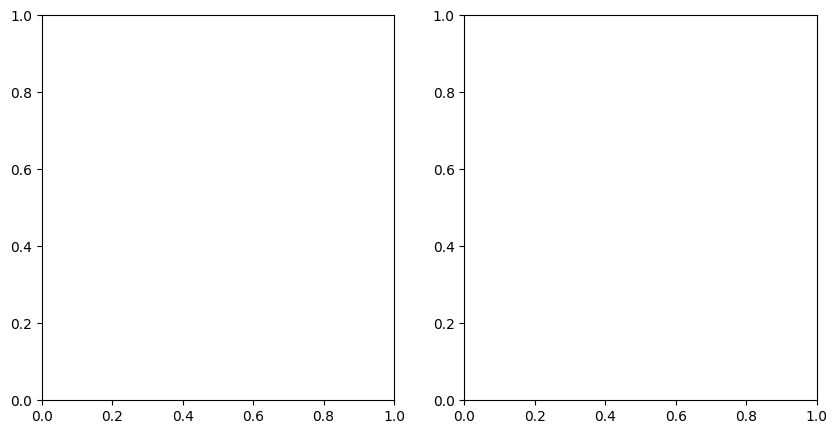

100%|██████████| 10/10 [00:16<00:00,  1.70s/it, last 100 eps R avg=-1027637, R=-1016703, ε=0.04, mem sz=|█                   | 8044/128000]


BaseEnv profiling:
Function Name                  Total Calls     Time (s)       Avg Time per Call (s)   
__init__                       1               0.0127         0.0127                  
_calculate_observation         8043            0.1055         0.0000                  
step                           8043            0.4422         0.0001                  
reset                          10              0.0005         0.0000                  
close                          1               1.6252         1.6252                  


In [4]:
memory = Memory(max_size=MEMORY_SIZE)
agent = Agent(
    network=QNetwork(DEVICE), 
    memory=memory, 
    optimizer=OPTIMIZER, 
    epsilon=START_EPSILON, 
    decay=DECAY, 
    n_actions=N_ACTIONS
)

if DOUBLE_AGENT:
    agent = DoubleAgent(
        network=QNetwork(DEVICE), 
        target_network=QNetwork(DEVICE), 
        memory=memory, 
        optimizer=OPTIMIZER, 
        epsilon=START_EPSILON, 
        decay=DECAY, 
        n_actions=N_ACTIONS,
        tau=TAU
    )

if os.path.exists(f"../saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}"):
    output = input("You seem to have already trained this model before, want to train it again?\n\t[y]/n?")
    if output in ["yes", "Yes", 'y', 'Y', '']:
        train(agent, RENDER_MODE)
    else:
        exit()
else:
    train(agent, RENDER_MODE)

In [5]:
post_network = QNetwork(DEVICE)
post_network.load(f"../saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}")

post_memory = Memory(max_size=MEMORY_SIZE)

post_agent = Agent(
    network=post_network, 
    memory=post_memory, 
    optimizer=OPTIMIZER, 
    epsilon=FINAL_EPSILON, 
    decay=DECAY,
    n_actions=N_ACTIONS
)

Using cpu device



In [6]:
env = gym.make(render_mode="human")
print(post_agent.run(env, steps_limit=2000))
env.close()

-1006725.0605382941
